In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import History
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# load the data
data = pd.read_csv('AAPL.csv', date_parser=True)
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
data['MA'] = ta.trend.SMAIndicator(data['Close'], window=20).sma_indicator()
data['EMA'] = ta.trend.EMAIndicator(data['Close'], window=20).ema_indicator()
bb = ta.volatility.BollingerBands(data['Close'], window=20, window_dev=2)
data['BB_upper'] = bb.bollinger_hband()
data['BB_middle'] = bb.bollinger_mavg()
data['BB_lower'] = bb.bollinger_lband()
data = data[['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Adj Close', 'RSI', 'MA', 'EMA', 'BB_upper', 'BB_middle', 'BB_lower']]
data = data.set_index('Date')

In [3]:
# remove NaN values
data = data.dropna()

print(data)

# split the data into training and test sets
train_size = int(len(data) * 0.7)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# scale the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# prepare the data for LSTM
def prepare_data(data, window_size):
    X, Y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])
        Y.append(data[i, 1]) # predict the Close value
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

window_size = 2
trainX, trainY = prepare_data(train_data, window_size)
testX, testY = prepare_data(test_data, window_size)

                  Open       Close        High         Low     Volume  \
Date                                                                    
2020-08-17  116.062500  114.607498  116.087502  113.962502  119561600   
2020-08-18  114.352501  115.562500  116.000000  114.007500  105633600   
2020-08-19  115.982498  115.707497  117.162498  115.610001  145538000   
2020-08-20  115.750000  118.275002  118.392502  115.732498  126907200   
2020-08-21  119.262497  124.370003  124.867500  119.250000  338054800   
...                ...         ...         ...         ...        ...   
2023-07-14  190.229996  190.690002  191.179993  189.630005   41573900   
2023-07-17  191.899994  193.990005  194.320007  191.809998   50520200   
2023-07-18  193.350006  193.729996  194.330002  192.419998   48353800   
2023-07-19  193.100006  195.100006  198.229996  192.649994   80507300   
2023-07-20  195.089996  193.130005  196.470001  192.500000   59581200   

             Adj Close        RSI          MA     

In [4]:
# build the LSTM model
model = Sequential()
model.add(LSTM(64, activation='sigmoid', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='sigmoid', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='sigmoid', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [5]:
# train the model
history = model.fit(trainX, trainY, epochs=2000, batch_size=100, shuffle=True, validation_data=(testX, testY), verbose=2)

Epoch 1/2000
6/6 - 1s - loss: 0.3553 - mse: 0.3553 - val_loss: 0.1266 - val_mse: 0.1266 - 1s/epoch - 225ms/step
Epoch 2/2000
6/6 - 0s - loss: 0.1219 - mse: 0.1219 - val_loss: 0.0541 - val_mse: 0.0541 - 33ms/epoch - 5ms/step
Epoch 3/2000
6/6 - 0s - loss: 0.1541 - mse: 0.1541 - val_loss: 0.0559 - val_mse: 0.0559 - 33ms/epoch - 5ms/step
Epoch 4/2000
6/6 - 0s - loss: 0.1274 - mse: 0.1274 - val_loss: 0.1004 - val_mse: 0.1004 - 32ms/epoch - 5ms/step
Epoch 5/2000
6/6 - 0s - loss: 0.1067 - mse: 0.1067 - val_loss: 0.1195 - val_mse: 0.1195 - 36ms/epoch - 6ms/step
Epoch 6/2000
6/6 - 0s - loss: 0.1056 - mse: 0.1056 - val_loss: 0.0904 - val_mse: 0.0904 - 31ms/epoch - 5ms/step
Epoch 7/2000
6/6 - 0s - loss: 0.1106 - mse: 0.1106 - val_loss: 0.0749 - val_mse: 0.0749 - 31ms/epoch - 5ms/step
Epoch 8/2000
6/6 - 0s - loss: 0.1036 - mse: 0.1036 - val_loss: 0.0816 - val_mse: 0.0816 - 33ms/epoch - 5ms/step
Epoch 9/2000
6/6 - 0s - loss: 0.1017 - mse: 0.1017 - val_loss: 0.0973 - val_mse: 0.0973 - 36ms/epoch - 6

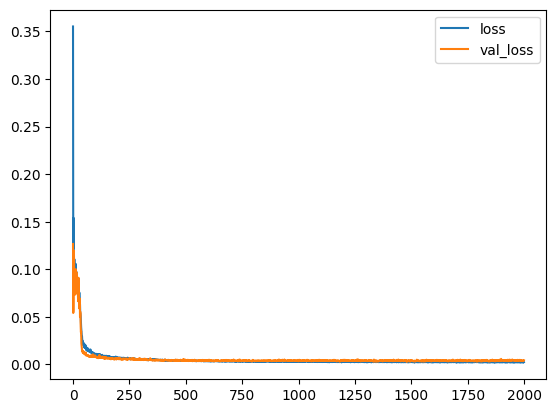

In [6]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [7]:
# make predictions on the test data
predictions = model.predict(testX)
for i in range(len(predictions)):
        print('predicted=%f, actual=%f' % (predictions[i], testY[i]))

print(predictions.shape)

7/7 [==============================] - 0s 2ms/step
predicted=0.652721, actual=0.634429
predicted=0.633600, actual=0.653452
predicted=0.645225, actual=0.633498
predicted=0.626249, actual=0.672210
predicted=0.670011, actual=0.752827
predicted=0.742051, actual=0.625249
predicted=0.631425, actual=0.644805
predicted=0.647763, actual=0.605694
predicted=0.605122, actual=0.583477
predicted=0.566802, actual=0.633763
predicted=0.622720, actual=0.665957
predicted=0.641390, actual=0.623653
predicted=0.621167, actual=0.610616
predicted=0.598995, actual=0.579886
predicted=0.564567, actual=0.584409
predicted=0.571435, actual=0.597579
predicted=0.584615, actual=0.572037
predicted=0.539264, actual=0.474125
predicted=0.481184, actual=0.417188
predicted=0.438772, actual=0.473726
predicted=0.474587, actual=0.522283
predicted=0.519198, actual=0.526274
predicted=0.516865, actual=0.513370
predicted=0.514549, actual=0.442331
predicted=0.453858, actual=0.446721
predicted=0.453068, actual=0.427564
predicted=0.4

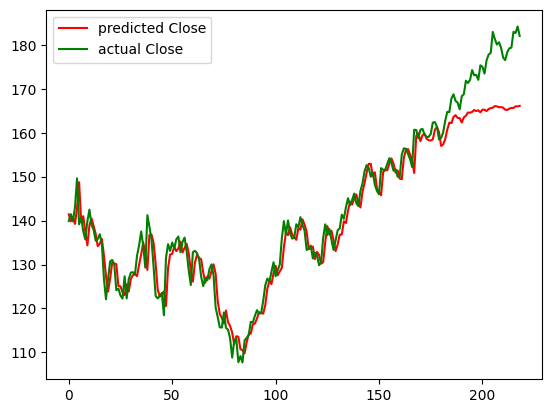

In [8]:
# create dummy columns for predictions
dummy_cols_pred = np.zeros((predictions.shape[0], train_data.shape[1]-1))
predictions = np.hstack((dummy_cols_pred, predictions))
unscaled_predictions = scaler.inverse_transform(predictions)[:, -1]

# create dummy columns for actual values
dummy_cols_actual = np.zeros((testY.shape[0], train_data.shape[1]-1))
actual = np.hstack((dummy_cols_actual, testY.reshape(-1, 1)))
unscaled_actual = scaler.inverse_transform(actual)[:, -1]

# plot the predicted and actual prices (unscaled)
plt.plot(unscaled_predictions, label='predicted Close', color='red')
plt.plot(unscaled_actual, label='actual Close', color='green')
plt.legend()
plt.show()

In [10]:
# calculate the mean squared error
mse = mean_squared_error(unscaled_actual, unscaled_predictions)
print(f'Mean Squared Error: {mse}')

# calculate the mean absolute error
mae = mean_absolute_error(unscaled_actual, unscaled_predictions)
print(f'Mean Absolute Error: {mae}')

# calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

#calculate the R2 score
r2_score = 1 - (np.sum((unscaled_actual - unscaled_predictions)**2)/np.sum((unscaled_actual - np.mean(unscaled_actual))**2))
print(f'R2 Score: {r2_score}')

Mean Squared Error: 29.001541242048965
Mean Absolute Error: 3.7166382139107412
Root Mean Squared Error: 5.385307905964984
R2 Score: 0.9191317048815879
